In [48]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [76]:
class CustomDataset(Dataset):
    CLASSES = ["Mold", "Peach"]
    CLASS_COLORS = [255, 128]  # Gray level format

    def __init__(
        self,
        root_path,
        images_paths,
        masks_paths,
        preprocessing=None,
    ):
        self.root_path = root_path
        self.images_fps = images_paths
        self.masks_fps = masks_paths

        self.images_fps = [
            os.path.join(root_path, "peach", image_id) for image_id in self.images_fps
        ]

        self.masks_fps = [
            os.path.join(root_path, "masks", image_id) for image_id in self.masks_fps
        ]

        self.classes = self.CLASSES
        self.class_colors = self.CLASS_COLORS[: len(self.classes)]
        self.preprocessing = preprocessing

    @staticmethod
    def get_nonblack_region(mask):
        mask_indices = np.argwhere(mask != 0)
        if len(mask_indices) == 0:
            return None
        (min_y, min_x), (max_y, max_x) = mask_indices.min(0), mask_indices.max(0) + 1
        return min_x, min_y, max_x, max_y

    def __getitem__(self, i):
        # Read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], cv2.IMREAD_GRAYSCALE)

        # Get bounding box around non-black regions in the mask
        bbox = self.get_nonblack_region(mask)

        if bbox:
            min_x, min_y, max_x, max_y = bbox
            # Crop the image and mask using the bounding box
            image = image[min_y:max_y, min_x:max_x]
            mask = mask[min_y:max_y, min_x:max_x]

        # Convert mold mask to one-hot encoded array
        mold_mask = (mask == 255).astype(np.float32)

        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mold_mask)
            image, mold_mask = sample["image"], sample["mask"]

        # Convert to PyTorch tensor
        image = torch.tensor(image, dtype=torch.float32)
        mold_mask = torch.tensor(mold_mask, dtype=torch.float32).unsqueeze(
            0
        )  # Add channel dimension

        return image, mold_mask

    def __len__(self):
        return len(self.images_fps)

In [77]:
# Define root path
root_path = "C:\\Users\\user\\Documents\\GitHub\\smart-fridge"

# Get image and mask paths
image_dir = os.path.join(root_path, "peach")
mask_dir = os.path.join(root_path, "masks")
image_paths = [os.path.join(image_dir, filename) for filename in os.listdir(image_dir)]
mask_paths = [os.path.join(mask_dir, filename) for filename in os.listdir(mask_dir)]

# Split data into training, validation, and test sets
train_image_paths, test_image_paths, train_mask_paths, test_mask_paths = (
    train_test_split(image_paths, mask_paths, test_size=0.15, random_state=42)
)
val_image_paths, test_image_paths, val_mask_paths, test_mask_paths = train_test_split(
    test_image_paths, test_mask_paths, test_size=0.5, random_state=42
)

# Define transformations
train_transform = A.Compose(
    [
        A.Resize(224, 224),  # Resize images to 224x224
        A.HorizontalFlip(p=0.2),  # Horizontal flip with probability 0.2
        A.VerticalFlip(p=0.2),  # Vertical flip with probability 0.2
        A.RandomBrightnessContrast(p=0.2),  # Random brightness/contrast adjustments# Normalize images
        ToTensorV2(),  # Convert image to PyTorch tensor
    ]
)

test_transform = A.Compose(
    [
        A.Resize(224, 224),  # Resize images to 224x224
        ToTensorV2(),  # Convert image to PyTorch tensor
    ]
)

In [78]:
len(train_image_paths), len(test_image_paths), len(val_image_paths)

(214, 19, 19)

In [79]:
# Create the train and test datasets
train_dataset = CustomDataset(
    root_path, train_image_paths, train_mask_paths, preprocessing=train_transform
)
test_dataset = CustomDataset(
    root_path, test_image_paths, test_mask_paths, preprocessing=test_transform
)
val_dataset = CustomDataset(
    root_path, val_image_paths, val_mask_paths, preprocessing=test_transform
)

# Create train and test data loaders
train_data_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
val_data_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

C:\Users\user\AppData\Local\Temp\ipykernel_864\1874902280.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)
C:\Users\user\AppData\Local\Temp\ipykernel_864\1874902280.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mold_mask = torch.tensor(mold_mask, dtype=torch.float32).unsqueeze(
C:\Users\user\AppData\Local\Temp\ipykernel_864\2609261475.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  axes[0].imshow(torch.tensor(image.permute(1, 2, 0),dtype=int))


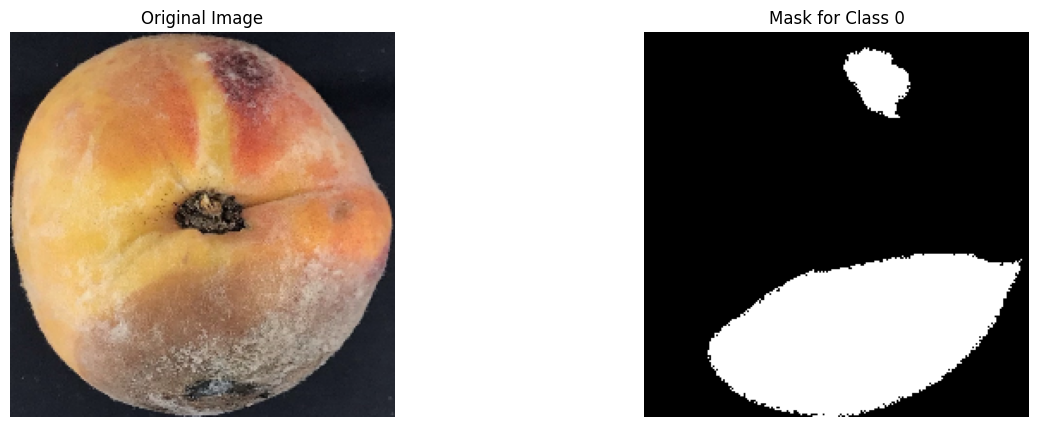

In [81]:
# Assuming `image` is a tensor obtained from the dataset
image, masks = train_dataset[3]

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot the original image

axes[0].imshow(torch.tensor(image.permute(1, 2, 0),dtype=int))
axes[0].set_title("Original Image")
axes[0].axis("off")

# Plot the first mask (for class 0)
axes[1].imshow(masks[0], cmap="gray")
axes[1].set_title("Mask for Class 0")
axes[1].axis("off")

plt.show()

In [91]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define early stopping parameters
patience = 3
min_delta = 0.001
n_epochs_stop = 10
epochs_no_improve = 0
best_val_loss = float("inf")

# Load pre-trained DeepLabV3 model
model = torch.hub.load("pytorch/vision:v0.10.0", "deeplabv3_resnet50", pretrained=True)


# Unfreeze last 4 layers for fine-tuning
unfreeze_layers = 4  # Number of layers to unfreeze
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the last `unfreeze_layers` layers
parameters = list(model.parameters())
for param in parameters[-unfreeze_layers:]:
    param.requires_grad = True

# Modify model head for mold segmentation
num_classes = 1  # Mold class only
model.classifier[-1] = nn.Conv2d(256, num_classes, kernel_size=1)

# Move model to CUDA if available
model = model.to(device)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Total Trainable Parameters:", total_params)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=2e-3)
criterion = nn.BCEWithLogitsLoss()

# Define learning rate scheduler based on validation loss
lr_scheduler = ReduceLROnPlateau(
    optimizer, mode="min", factor=0.2, patience=patience, verbose=True
)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, masks in tqdm(train_data_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        # Move data to CUDA
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)["out"]
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(train_dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss}")

    # Validation loop
    model.eval()
    val_loss = 0.0
    for images, masks in val_data_loader:
        # Move data to CUDA
        images, masks = images.to(device), masks.to(device)

        outputs = model(images)["out"]
        loss = criterion(outputs, masks)
        val_loss += loss.item() * images.size(0)
    val_loss /= len(val_dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss}")

    # Update learning rate scheduler
    lr_scheduler.step(val_loss)

    # Early stopping
    if val_loss < best_val_loss - min_delta:
        epochs_no_improve = 0
        best_val_loss = val_loss
    else:
        epochs_no_improve += 1
        if epochs_no_improve == n_epochs_stop:
            print("Early stopping!")
            break


# Evaluate on test dataset
model.eval()
test_loss = 0.0
for images, masks in test_data_loader:
    # Move data to CUDA
    images, masks = images.to(device), masks.to(device)

    outputs = model(images)["out"]
    loss = criterion(outputs, masks)
    test_loss += loss.item() * images.size(0)
test_loss /= len(test_dataset)
print(f"Test Loss: {test_loss}")

# Save trained model
torch.save(model.state_dict(), "mold_segmentation_model.pth")

Using cache found in C:\Users\user/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Total Trainable Parameters: 6166


Epoch 1/100:   0%|          | 0/14 [00:00<?, ?it/s]C:\Users\user\AppData\Local\Temp\ipykernel_864\1874902280.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)
C:\Users\user\AppData\Local\Temp\ipykernel_864\1874902280.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mold_mask = torch.tensor(mold_mask, dtype=torch.float32).unsqueeze(
Epoch 1/100:  14%|█▍        | 2/14 [00:03<00:21,  1.83s/it]


KeyboardInterrupt: 

C:\Users\user\AppData\Local\Temp\ipykernel_864\1874902280.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)
C:\Users\user\AppData\Local\Temp\ipykernel_864\1874902280.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mold_mask = torch.tensor(mold_mask, dtype=torch.float32).unsqueeze(
C:\Users\user\AppData\Local\Temp\ipykernel_864\1083836758.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  axes[i, 0].imshow(torch.tensor(image.permute(1, 2, 0),dtype=int).cpu().numpy())


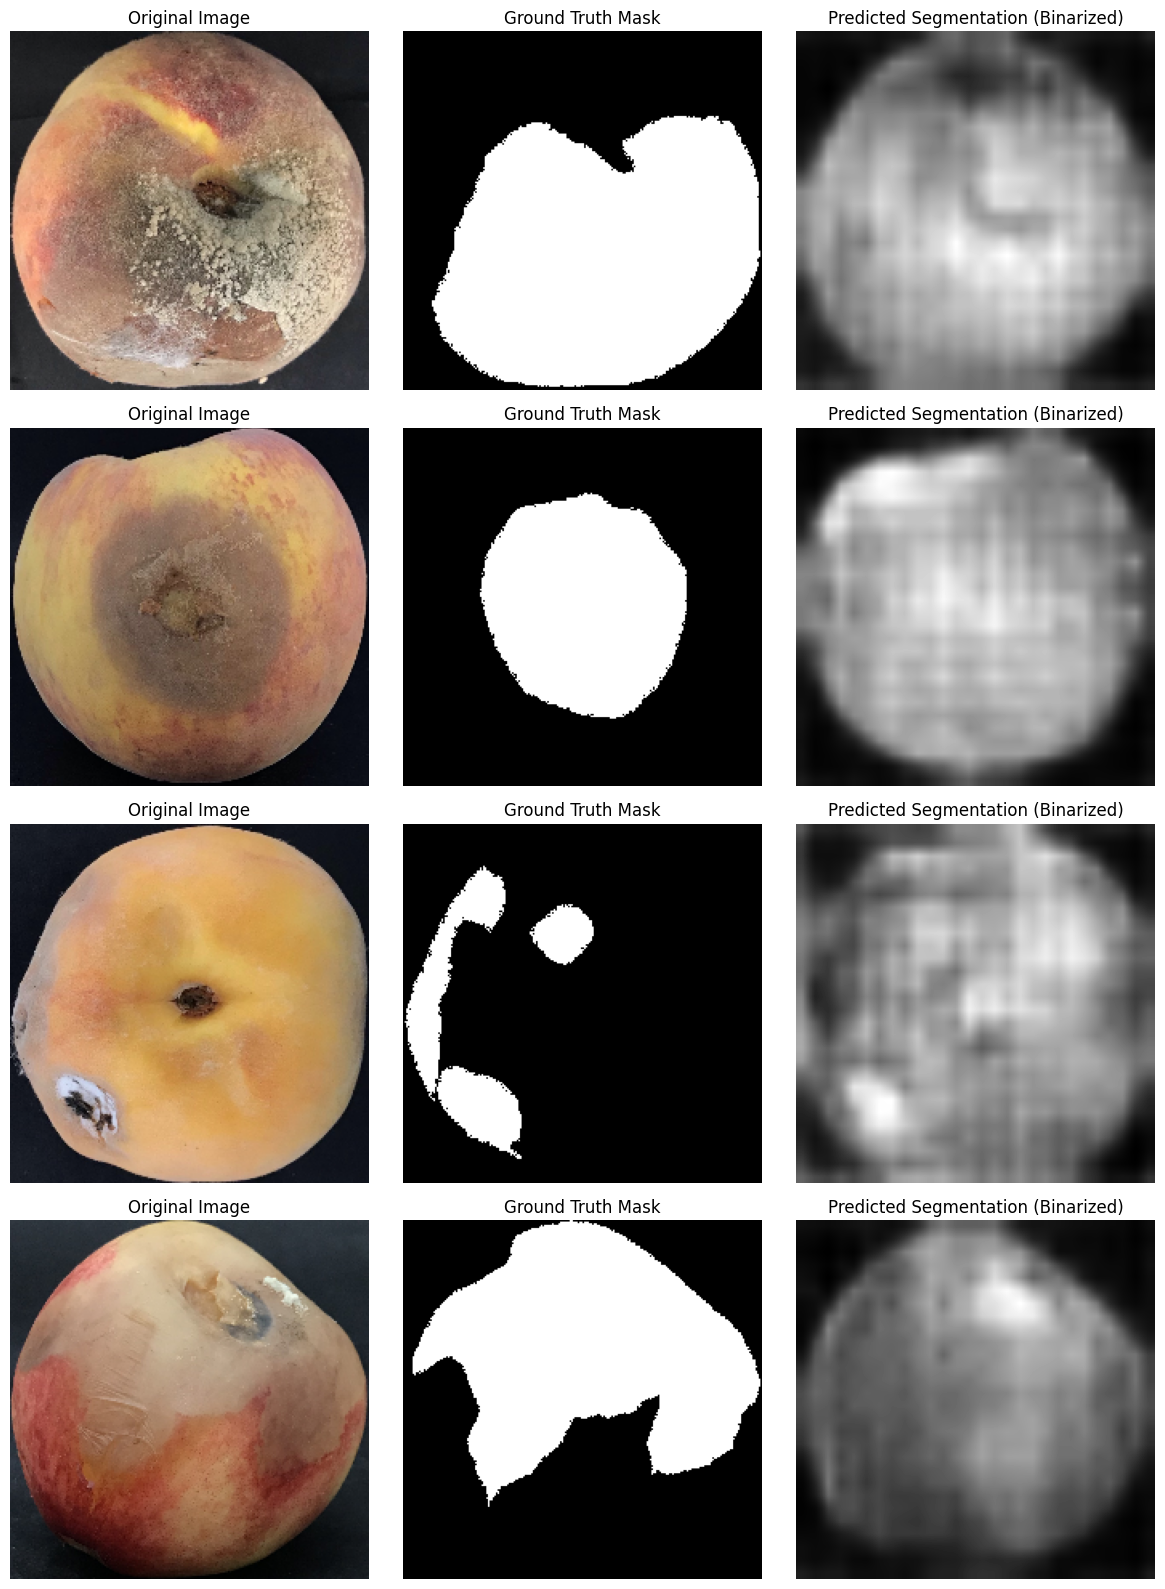

In [89]:
import matplotlib.pyplot as plt
import numpy as np

# Select 4 random indices from the test dataset
indices = np.random.choice(len(test_dataset), size=4, replace=False)

# Create a 4x3 subplot grid
fig, axes = plt.subplots(4, 3, figsize=(12, 16))

# Iterate over the selected indices
for i, idx in enumerate(indices):
    # Get the image and mask from the test dataset
    image, mask = test_dataset[idx]

    # Move the image to the same device as the model
    image = image.to(device)

    # Predict the segmentation mask using the model
    with torch.no_grad():
        model.eval()
        output = model(image.unsqueeze(0))["out"]
        pred_mask = torch.sigmoid(output).squeeze().cpu().numpy()

    # Binarize the predicted mask using thresholding at 0.5
    binarized_pred_mask = (pred_mask > 0.5).astype(np.uint8)

    # Plot the original image
    axes[i, 0].imshow(torch.tensor(image.permute(1, 2, 0),dtype=int).cpu().numpy())
    axes[i, 0].set_title("Original Image")
    axes[i, 0].axis("off")

    # Plot the ground truth mask
    axes[i, 1].imshow(mask.squeeze().cpu().numpy(), cmap="gray")
    axes[i, 1].set_title("Ground Truth Mask")
    axes[i, 1].axis("off")

    # Plot the predicted segmentation mask
    axes[i, 2].imshow(pred_mask, cmap="gray")
    axes[i, 2].set_title("Predicted Segmentation (Binarized)")
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()